# CNNs and Ice core data

In this exercise we are going to be classifying ashes found in ice core drilling. We will be dealing with a dataset (provided by Niccolo Maffezzoli, a former TA in 'Applied Statistics') that labels images and meta-data into two types of volcanic ashes: _Grimsvotn_ og _Campanian_.

The data for this exercise consists of both scalar values (.csv files) and images (in directories), already split into training and testing samples, and can be found here:
https://sid.erda.dk/share_redirect/gqwa15no19

Your task will be to make the best classifier. First you will make a classifier based on the image data alone, then one based on the meta data alone, and finally one that combines both. You are free to use whatever methods you wish, but ideas will be provided... :)

NOTE: The data should be placed *in the same directory as the code* in order for the code to run out of the box.

***

Author: Niccolo Maffezzoli, Amalie Mygind, and Troels Petersen

Email: petersen@nbi.dk

Date: 5th of May 2024 (latest version)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

### Loading, splitting the data

In [2]:
train_df = pd.read_csv('supervised_train.csv')
train, val = train_test_split(train_df, test_size=0.3, random_state=42)
test = pd.read_csv('supervised_test.csv')

We will be using PyTorch's DataLoader to make batches of our data.

In [3]:
cols_mva = ['Area (ABD)', 'Area (Filled)', 'Aspect Ratio', 'Biovolume (Cylinder)',
       'Biovolume (P. Spheroid)', 'Circle Fit',
       'Circularity', 'Circularity (Hu)', 'Compactness', 'Convex Perimeter',
       'Convexity', 'Diameter (ABD)', 'Diameter (ESD)', 'Edge Gradient',
       'Elongation', 'Feret Angle Max', 'Feret Angle Min', 'Fiber Curl',
       'Fiber Straightness', 'Geodesic Aspect Ratio', 'Geodesic Length',
       'Geodesic Thickness', 'Intensity', 'Length', 'Particles Per Chain',
       'Perimeter', 'Roughness', 'Sigma Intensity', 'Sum Intensity',
       'Symmetry', 'Transparency', 'Volume (ABD)', 'Volume (ESD)', 'Width']

class ParticleDataset():
    # This class is simply a "list-like" object
    # that will load an image on the fly (using Image.open).
    
    def __init__(self, df):
        self.df = df
        self.imgpaths = df['imgpaths'].to_numpy()
        # self.imgpaths = df[path+'train/'].to_numpy()
        self.labels = df['class'].to_numpy()
        scaler = StandardScaler()
        self.X_features = scaler.fit_transform(df[cols_mva])
        
        # Feel free to change these transforms! They are not optimal.
        # You could also include e.g. RandomHorizontalFlip, RandomVerticalFlip
        # for data augmentation.
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)), 
            transforms.ToTensor(),
            transforms.Normalize(mean=[94/255], std=[12/255]),
            ])

    def __len__(self):
        return len(self.df)   # you can limit the number of images by returning a smaller number here

    def __getitem__(self, idx):
        imgpath = self.imgpaths[idx]
        image = self.transform(Image.open(imgpath))        
        
        label = torch.tensor(self.labels[idx]).int()
        xfeatures = torch.from_numpy(self.X_features[idx]).float()
        
        return image, label, xfeatures

    
batch_size = 32

dataloader_train = DataLoader(ParticleDataset(train), batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(ParticleDataset(val), batch_size=batch_size, shuffle=True)
dataloader_test = DataLoader(ParticleDataset(test), batch_size=batch_size, shuffle=True)

We now have data loaders that can sample from our data. These can be used in a loop:

In [4]:
for img, label, meta_features in dataloader_train:
    print('Image batch shape =', img.shape)
    print('Label batch shape =', label.shape)
    print('Meta features batch shape =', meta_features.shape)
    break

Image batch shape = torch.Size([32, 1, 128, 128])
Label batch shape = torch.Size([32])
Meta features batch shape = torch.Size([32, 34])


(array([3463., 3537.]),
 array([0., 1., 2.]),
 <BarContainer object of 2 artists>)

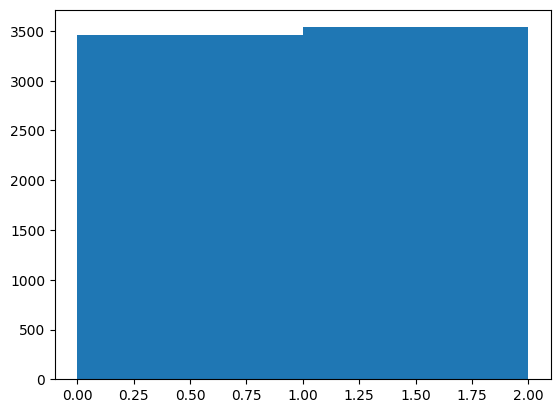

In [5]:
labels = []

for _, label, _ in dataloader_train:
    labels.append(label)

labels = torch.cat(labels)
# histogram of labels
plt.hist(labels.numpy(), bins=range(3))

Let us have a look at a few of the images:

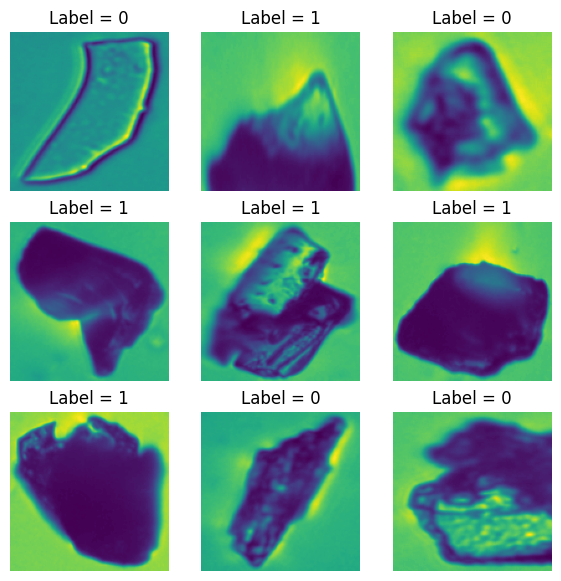

In [6]:
# Try running this cell many times -- new batches are generated each time:
plt.figure(figsize=(7, 7))
for img, label, meta_features in dataloader_train:
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(img[i, 0, :, :])
        plt.axis('off')
        plt.title(f'Label = {int(label[i])}')
    break

## An example network:

This network is rather small and does not include many of the features it potentially could (see exercise 1).

Once again, try to draw the CNN, and think about how many parameters it has.

In [7]:
# Input image size = 1 x 128 x 128  (1 channel, i.e. bw)
net = nn.Sequential(nn.Conv2d(1, 3, 5),  # shape = (3, 124 x 124)
                    nn.ReLU(),           # shape = (3, 124 x 124), see https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
                    nn.MaxPool2d(10),    # shape = (3, 12 x 12), see https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html
                    nn.Flatten(),        # shape = (3 * 12 * 12) = (432)
                    nn.Linear(432, 1),   # shape = (1)
                    nn.Sigmoid())        # shape (1)

This network takes a batch of images (batch x 1 x image_width x image_height) and returns a single number for each image (batch x 1):

In [8]:
for img, label, meta_features in dataloader_train:
    print(net(img).shape)
    break

torch.Size([32, 1])


You do not need to calculate shapes yourself. You can always ask with `.shape`.

We could also have made this networks more explicitely by using a class:

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 5)
        self.nonlinearity = nn.ReLU()
        self.mp1 = nn.MaxPool2d(10)
        self.linear1 = nn.Linear(432, 1)
        self.to_prop = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.nonlinearity(x)
        x = self.mp1(x)
        return self.to_prop(self.linear1(x.view(x.shape[0], -1)))
    
net = Net()

In [10]:
for img, label, meta_features in dataloader_train:
    print(net(img).shape)
    break

torch.Size([32, 1])


The two definitions are exactly the same, but, naturally, the latter is a lot more customizable.

We are going to intepret the output of the model as being the probability of class 1. The `Sigmoid` at the end ensures that it is a number in [0, 1]

In [11]:
for img, label, meta_features in dataloader_train:
    output = net(img)
    print(output.min(), output.max())
    break

tensor(0.2396, grad_fn=<MinBackward1>) tensor(0.7031, grad_fn=<MaxBackward1>)


## An example training routine

All the parameters of our model can be found using `.parameters()`. We make an optimizer and tell it to optimize over these paramters:

In [12]:
opt = torch.optim.Adam(net.parameters(), lr=1e-4)  # lr = learning rate

We are also going to use a GPU, if we have one:

In [13]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cpu"
net.to(device)
print('Running on', device)

Running on cpu


To train we loop over epochs and the dataset:

In [14]:
loss_criterion = nn.BCELoss()
for epoch in range(5):
    acc_loss = 0.0
    for img, label, meta_features in tqdm(dataloader_train, desc=f'Epoch {epoch + 1}'):
        img = img.to(device)
        output = net(img).squeeze()
        label = label.float().to(device)
        loss = loss_criterion(output, label)
        loss.backward()  # calculate gradients: d Loss / d Paramters
        opt.step()  # take a step down-hill
        opt.zero_grad()  # zero the gradient calculations for next iteration
        acc_loss += float(loss)
    acc_loss /= len(dataloader_train)
    print(f'Epoch {epoch + 1} loss = {acc_loss}')
    

Epoch 1: 100%|██████████| 219/219 [00:08<00:00, 26.46it/s]


Epoch 1 loss = 0.3914627472967862


Epoch 2: 100%|██████████| 219/219 [00:07<00:00, 27.56it/s]


Epoch 2 loss = 0.27187999851627437


Epoch 3: 100%|██████████| 219/219 [00:08<00:00, 27.25it/s]


Epoch 3 loss = 0.2560495475825926


Epoch 4: 100%|██████████| 219/219 [00:08<00:00, 27.18it/s]


Epoch 4 loss = 0.24531920033094545


Epoch 5: 100%|██████████| 219/219 [00:07<00:00, 27.51it/s]

Epoch 5 loss = 0.2376935880580177


After we have trained a model, we should evaluate its accuracy:

In [14]:
def calc_accuracy(model, dataset, only_img=True, only_meta=False):
    acc = 0.0
    count = 0
    with torch.no_grad():
        net.eval()
        for img, label, meta_features in dataset:
            label = label.to(device)
            img = img.to(device)
            meta_features = meta_features.to(device)
            
            if only_img:
                output = model(img).squeeze()
            elif only_meta:
                output = model(meta_features).squeeze()
            else:
                output = model(img, meta_features).squeeze()
            
            prediction = torch.round(output)
            acc += torch.sum(torch.eq(prediction, label))
            count += len(label)
    return acc / count
            
print(f'Train accuracy = {float(calc_accuracy(net, dataloader_train))}')
print(f'Test accuracy = {float(calc_accuracy(net, dataloader_test))}')

Train accuracy = 0.8945714235305786
Test accuracy = 0.8940000534057617


## Exercise 1

The above model was okay, but not fantastic. Your job is to make a good CNN model. 

You should plot both the average loss and accuracy on both training and validation data as you train.
Finally, evaluate your model on the test data.

#### Notes to exercise 1

Feel free to take inspiration from online examples. Some nice functions to use could be: `nn.Conv2d, nn.BatchNorm2d, nn.MaxPool2d, nn.Dropout...`.

If you use `BatchNorm2d` and `Dropout`, you need to switch your network between train and evaluation mode appropriately: `net.train()`, `net.eval()`.

In the current model, we use `nn.Sigmoid` at the end. This is a bit unstable, and it is smarter to simply omit this step and use `nn.BCEWithLogitsLoss()` instead of `nn.BCELoss()`.

If you really want your model to perform, you can also use a pretrained model, e.g. `torchvision.models.resnet18`, as a backbone to your model.

## Exercise 2

Make a model that uses the meta features instead of the images (possibly using PyTorch):

In [19]:
for img, label, meta_features in dataloader_train:
    print(meta_features[0])
    break

tensor([ 0.1971,  0.1206, -1.3377, -0.0333, -0.2724, -1.0986,  0.2619, -0.6741,
        -0.3617,  0.4593,  0.5030,  0.4628,  0.4594,  1.2629, -0.3590,  1.1245,
        -0.3363, -0.7107,  0.8332, -0.0438, -0.0420,  0.3645, -1.3563,  0.7411,
        -0.0338,  0.0187, -0.8433, -0.8406, -0.1846,  1.1361, -0.2568, -0.0161,
         0.0098, -0.3308])


## Exercise 3

Combine your previous two models into one that uses both image and meta data. To do this, you should make a `Net(nn.Module)` class as demonstrated above. The `forward` function should then take both an image and a feature vector.

## Learning points:

This is a more involved CNN exercise than on the MNIST data, yet many of the learning points are the same:
1. CNNs are the goto model for image analysis.
2. They work by convoluting the input images with kernels that are trained to recognise certain features in the image (not unlike neurons in an ordinary NN).
2. Your CNN considerations should include:
     - Sample and image sizes (enough training and testing data?),
     - CNN architecture (size and number of kernels),
     - Batch size (optimising how fast you converge), and
     - if you need GPUs for the problem!
3. CNNs can be implemented in (Keras) TensorFlow (easiest) and PyTorch (harder but more versatile).

One consideration that much can be learned from is asking yourself (and peers), if you could go through the above exercise using Keras TensorFlow? If this is the case, then you can at least claim good understanding of the CNN ingredients :-)